In [1]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [2]:
df = pd.read_csv('Train.csv')
sample_sub = pd.read_csv('SampleSubmission.csv')
df.shape, sample_sub.shape

((1109, 2), (1017, 194))

In [3]:
#########################
# Augmentation methods
#########################
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

####################################
# the confusion matrix heat map plot
####################################
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Explore Augmentation method

So before we go full scale application of the augmentation methods, lets take one audio file and run it through all the different types to get a feel for how they work. From there we'll then take a few forward for our model training and hopefully it improves our accuracy.

We'll start with the orginal audio file untouched...

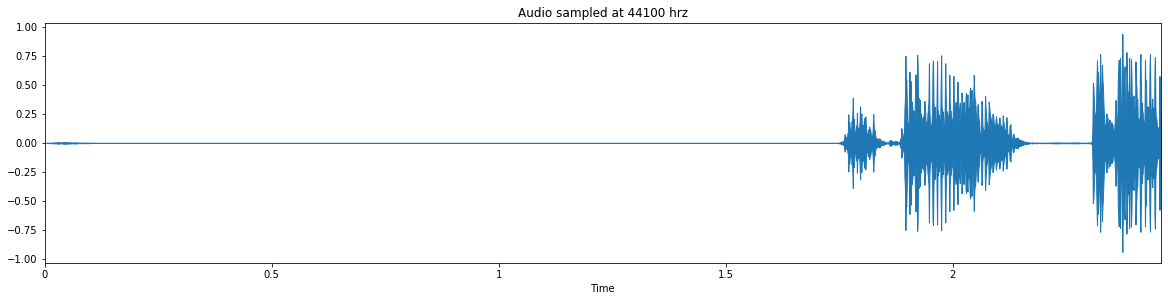

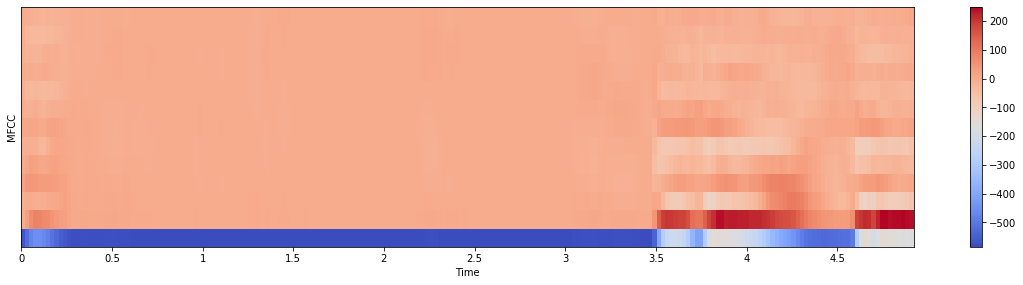

In [4]:
#Visualizing a few files and comparing their MFCCs
sr = 44100
path = "audio_files/IV38R7F.wav"
data, sample_rate = librosa.load(path, res_type='kaiser_fast',sr=22050*2)  
mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(data, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data, rate=sr)

### 1. Static noise

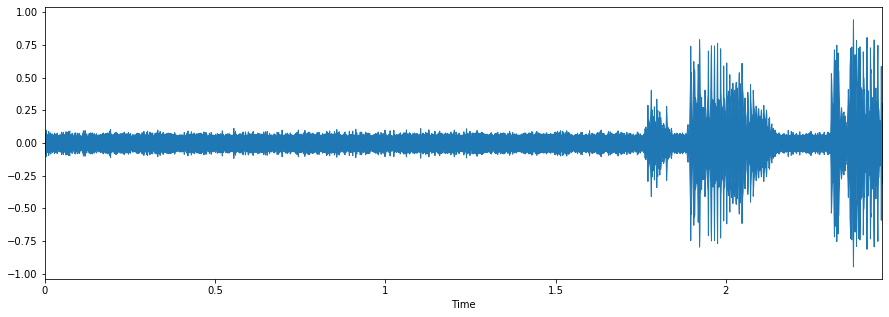

In [5]:
#Adding static(white noise) to the background

x = noise(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)

### 2. Shift Augmentation method

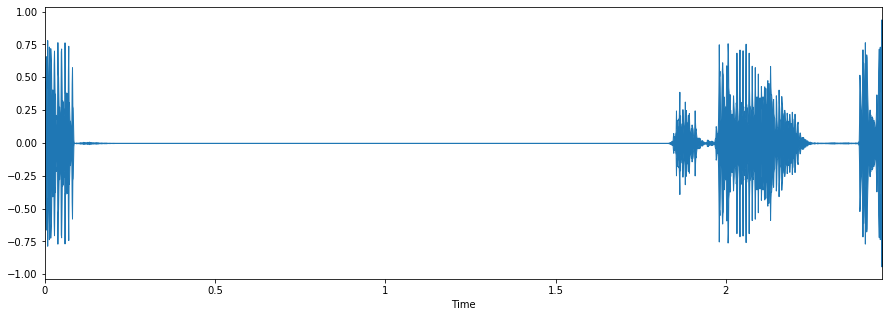

In [6]:
x = shift(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)

Notice how it shifted and distorted our audio real bad...it even shifted the silence at the beginning to the middle.this may not be a good method for our work as it may confuse the model

### 3. Stretch
Now we go to stretch, my most favourite augmentation method

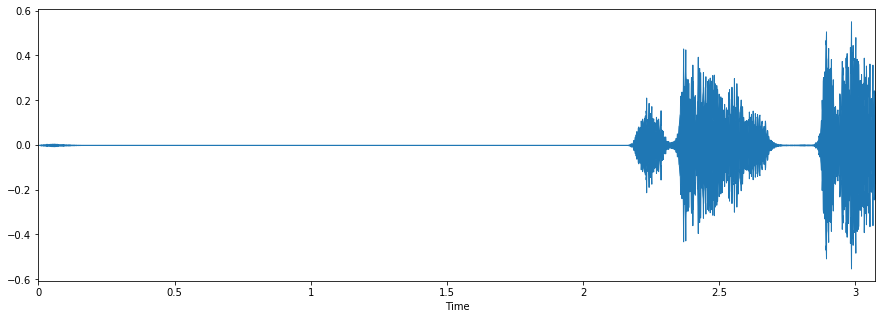

In [7]:
x = stretch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)

Notice how the length of time increased from 2.5s to 3s ...it stretched the audio.

This one is one of the more dramatic augmentation methods. The method literally stretches the audio. So the duration is longer, but the audio wave gets strecthed too. Thus introducing and effect that sounds like a slow motion sound. If you look at the audio wave itself, you'll notice that compared to the orginal audio, the strected audio seems to hit a higher frequency note. Thus creating a more diverse data for augmentation. Pretty nifty eh? It does introduce abit of a challenge in the data prep stage cause it lengthens the audio duration. Something to consider especially when doing a 2D CNN.




### 4. Pitch
I believe, this method accentuates the high pitch notes, by... normalising it sort of.

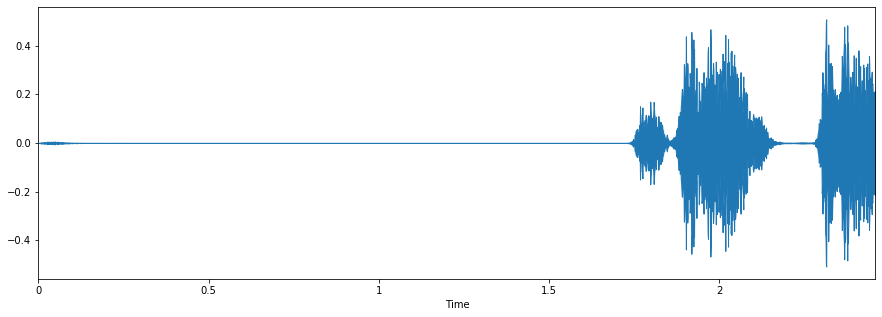

In [8]:
x = pitch(data, sr)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)

Honestly, I'm not exactly sure how this pitch augmentation works. so I'll need to do more reading on this. But safe to say it's another way of augmenting the data. If you listen to it, you can hear the difference.

### 5. Dynamic Change

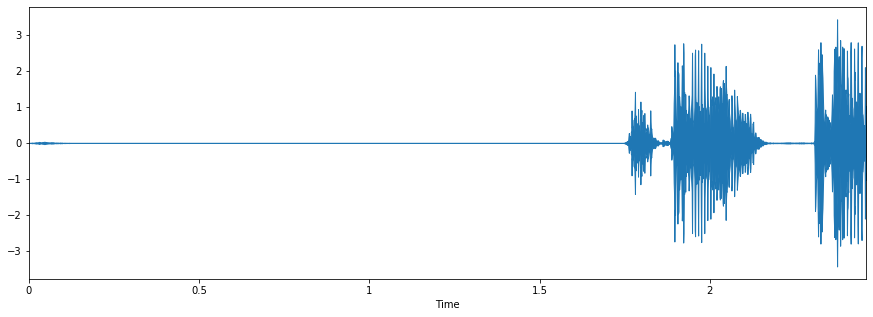

In [9]:
x = dyn_change(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)

Yes I know what you are thinking. It's exactly the same as the original. Yes true, but if you look at the frequency, the wave hits higher frequency notes compared to the original where the min is around -1 and the max is around 1. The min and max of this audio is -2 and 2 respestively. Not exactly sure how useful this is, I'll need to do some more reading.

### 6. Speed and Pitch

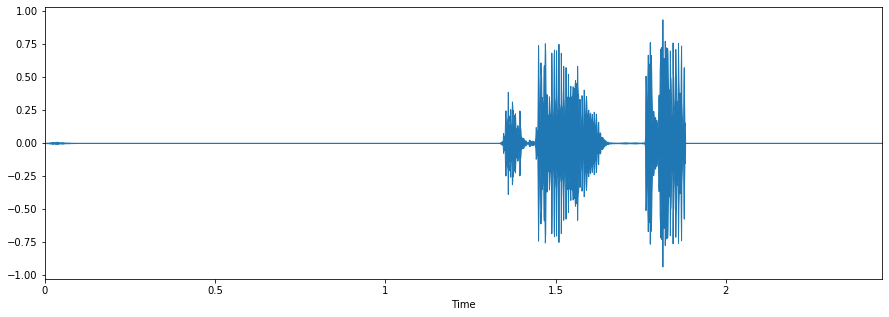

In [10]:
x = speedNpitch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sr)
ipd.Audio(x, rate=sr)

I really like this augmentation method. It dramatically alters the audio in many ways.Notice that It increases the pitch and speed of speech.  It compresses the audio wave but keeping the audio duration the same. If you listen to it, the effect is opposite of the stretch augmentation method. In cases like emotional detection/recognition, this could be counter-productive(not sure) as it changes angry tone to a seemingly neutral or happy tone. Another potential, downside is that there will be silence in the later part of the audio.

# 2. Data preparation and processing
I'm going to use just 2 augmentation method which is the noise, and the speed & pitch method. So now lets apply it across all our audio data. We'll use the same data processing steps as before, except we add in the augmentation process in the loop. We are going to use the noise and speed pitch augmentation method

Also, I have also added one extra enhancement to the code, which is a progress bar using the tqdm library. Given that we're adding a few extra processing steps, it would be worthwhile to know how long we've progressed...

In [11]:
#Processing and Augmenting

dff = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
cnt = 0

# loop feature extraction over the entire dataset
for file in tqdm(df['fn']):
    
    # first load the audio 
    X, sample_rate = librosa.load(file
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  
                                 )

    # take mfcc and mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=np.array(sample_rate), 
                                        n_mfcc=13),
                    axis=0)
    
    dff.loc[cnt] = [mfccs]   

    # random shifting (omit for now)
    # Stretch
    # pitch (omit for now)
    # dyn change
    
    # noise 
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_noise.loc[cnt] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_speedpitch.loc[cnt] = [aug]   

    cnt += 1

dff.head()

100%|██████████| 1109/1109 [03:38<00:00,  5.10it/s]


,feature
0,"[-44.77324, -39.253258, -31.491854, -30.133383..."
1,"[-11.288435, -1.3717802, 2.7510173, 4.80323, 4..."
2,"[8.021849, 10.738857, 11.262934, 11.8402405, 1..."
3,"[-30.089832, -29.324013, -28.87491, -27.209444..."
4,"[-41.03587, -34.62066, -18.434624, -16.746412,..."


Instead of the one data object that we get out, we now get 2 other ones, one for each of the 2 augmentation methods we've used.

We'll need to stack them on top of each other to make a larger dataset. But before we do so, we need to make sure the number of columns for the 3 datasets are the same. So lets check it out before we stack them

NOTE: If using the stretch augmentation, the audio duration becomes artifically longer and thus the number of columns will be different from original. So some padding will need to be done to the original dataset

In [12]:
# combine 
dff = pd.concat([df,pd.DataFrame(dff['feature'].values.tolist())],axis=1)
df_noise = pd.concat([df,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
df_speedpitch = pd.concat([df,pd.DataFrame(df_speedpitch['feature'].values.tolist())],axis=1)
print(dff.shape,df_noise.shape,df_speedpitch.shape)

(1109, 218) (1109, 218) (1109, 218)


Great so the shape of all the 3 datasets are the same. Thats expected. So our new dataset once stacked on top, will be 3 times the original size, which is handy since Deep Learning needs alot of data

In [13]:
#stacking the 3 datasets together
dff = pd.concat([dff,df_noise,df_speedpitch],axis=0,sort=False)
dff=dff.fillna(0)

dff.head()

,fn,label,0,1,2,3,4,5,6,7,...,206,207,208,209,210,211,212,213,214,215
0,audio_files/IV38R7F.wav,akawuka,-44.773239,-39.253258,-31.491854,-30.133383,-33.960716,-35.793442,-33.051308,-34.015152,...,-10.956895,-10.863541,-11.556558,-11.044641,-11.525646,-6.099812,0.000000,0.000000,0.000000,0.000000
1,audio_files/KM4SKWT.wav,banana,-11.288435,-1.371780,2.751017,4.803230,4.790741,1.651309,-0.412495,0.585379,...,6.969593,3.526595,2.636493,4.278601,4.706738,7.144873,7.782613,7.493994,6.322552,3.820127
2,audio_files/F5POSU9.wav,obulwadde,8.021849,10.738857,11.262934,11.840240,10.762719,6.276207,4.340938,2.413251,...,7.070533,7.846087,7.603508,8.561801,10.041899,8.293550,5.717575,5.289046,7.331453,8.375529
3,audio_files/MMVDXG2.wav,nnyaanya,-30.089832,-29.324013,-28.874910,-27.209444,-24.818371,-24.910892,-26.006748,-25.727741,...,-4.159011,-4.322663,-4.408619,-4.831316,-4.881852,-2.832334,0.000000,0.000000,0.000000,0.000000
4,audio_files/9TVM96F.wav,pampu,-41.035870,-34.620659,-18.434624,-16.746412,-24.933903,-29.880964,-29.128811,-31.251930,...,-26.394936,-28.571432,-31.340599,-29.104830,-29.183437,-30.648743,-34.224022,-35.549515,-26.576780,-17.687740


In [14]:
#Definning X and Y

y = dff['label']
X  = dff.drop(['fn', 'label'], axis=1)

In [15]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(dff.drop(['fn','label'],axis=1)
                                                      , dff.label
                                                     , test_size=0.25
                                                   , shuffle=True
                                                , random_state=42
                                                      , stratify = y     
                                                   )

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2495, 216), (832, 216), (2495,), (832,))

In [17]:
len(y_train.unique()), len(y_test.unique())

(193, 193)

In [18]:
# Lets do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
274,-0.487697,-0.495977,-0.403871,-0.409380,-0.444038,-0.431187,-0.428035,-0.382102,-0.356285,-0.397040,...,0.001545,0.041956,0.130126,0.109730,0.144328,0.188002,0.212740,0.215311,0.213639,0.214418
849,-0.236325,-0.292222,-0.424413,-0.334018,-0.348822,-0.377817,-0.537215,-0.627081,-0.623105,-0.655484,...,0.308960,0.274215,0.423677,0.474843,0.495494,0.481293,0.212740,0.215311,0.213639,0.214418
397,0.301398,0.326524,0.396088,0.445483,0.438044,0.470079,0.346164,0.369948,0.508417,0.509847,...,0.728305,0.678690,0.485743,0.569093,0.686105,0.643214,0.212740,0.215311,0.213639,0.214418
282,-1.026394,-1.041388,-1.001451,-0.995986,-1.023489,-1.051739,-0.956913,-0.795132,-0.751759,-0.858065,...,-0.847190,-0.846233,-0.845897,-0.846691,-0.846527,-0.864935,0.212740,0.215311,0.213639,0.214418
401,-0.801069,-0.801683,-0.805525,-0.728100,-0.637307,-0.644278,-0.651799,-0.630958,-0.612940,-0.620166,...,-2.120090,-2.121105,-2.122985,-2.125286,-2.127757,-2.127433,0.212740,0.215311,0.213639,0.214418
826,0.268106,0.285978,0.327940,0.233597,0.233315,0.129571,0.043800,0.133475,0.213645,0.132930,...,0.479927,0.442560,0.362315,0.344756,0.325918,0.283887,0.212740,0.215311,0.213639,0.214418
978,2.104565,2.118682,2.105715,2.031583,2.025735,1.975691,2.078144,2.145303,2.102641,2.058799,...,1.999354,2.074103,2.013472,1.961493,2.018785,1.899250,0.807068,0.871701,0.775552,0.411819
1042,-0.915050,-0.945795,-0.904032,-0.883655,-0.875398,-0.888957,-0.887829,-0.891313,-0.908332,-0.905049,...,-0.670538,-0.669308,-0.668664,-0.669249,-0.668719,-0.689726,0.212740,0.215311,0.213639,0.214418
938,-0.924130,-0.967967,-0.928441,-0.907277,-0.905599,-0.916299,-0.934035,-0.946299,-0.955874,-0.946881,...,-0.681258,-0.680045,-0.679420,-0.680018,-0.679510,-0.700360,0.212740,0.215311,0.213639,0.214418
339,-1.088962,-1.126830,-1.123887,-1.105718,-1.115685,-1.108979,-1.096166,-1.099977,-1.105212,-1.098655,...,-0.856564,-0.855623,-0.855303,-0.856108,-0.855963,-0.874233,0.212740,0.215311,0.213639,0.214418


In [19]:
# Lets few preparation steps to get it into the correct array format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(2495, 216)
['Pump' 'Spinach' 'abalimi' 'afukirira' 'agriculture' 'akammwanyi'
 'akamonde' 'akasaanyi' 'akatunda' 'akatungulu' 'akawuka' 'amakoola'
 'amakungula' 'amalagala' 'amappapaali' 'amatooke' 'banana' 'beans'
 'bibala' 'bulimi' 'butterfly' 'cabbages' 'cassava' 'caterpillar'
 'caterpillars' 'coffee' 'crop' 'ddagala' 'dig' 'disease' 'doodo'
 'drought' 'ebbugga' 'ebibala' 'ebigimusa' 'ebijanjaalo' 'ebijjanjalo'
 'ebikajjo' 'ebikolo' 'ebikongoliro' 'ebikoola' 'ebimera' 'ebinyebwa'
 'ebirime' 'ebisaanyi' 'ebisooli' 'ebisoolisooli' 'ebitooke' 'ebiwojjolo'
 'ebiwuka' 'ebyobulimi' 'eddagala' 'eggobe' 'ejjobyo' 'ekibala'
 'ekigimusa' 'ekijanjaalo' 'ekikajjo' 'ekikolo' 'ekikoola' 'ekimera'
 'ekirime' 'ekirwadde' 'ekisaanyi' 'ekitooke' 'ekiwojjolo' 'ekyeya'
 'emboga' 'emicungwa' 'emisiri' 'emiyembe' 'emmwanyi' 'endagala' 'endokwa'
 'endwadde' 'enkota' 'ennima' 'ennimiro' 'ennyaanya' 'ensigo'
 'ensiringanyi' 'ensujju' 'ensuku' 'ensukusa' 'enva endiirwa' 'eppapaali'
 'faamu' 'farm' 'farmer' 

In [20]:
#Adding an extra dimension
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(2495, 216, 1)

# MODELLING

In [21]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(193)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt = keras.optimizers.Adam(lr=0.0001)
#opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 256)           0

In [45]:
#compiling the model
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), verbose=2)

Epoch 1/10
78/78 - 41s - loss: 0.0055 - accuracy: 0.9984 - val_loss: 3.6373 - val_accuracy: 0.3726
Epoch 2/10
78/78 - 46s - loss: 0.0021 - accuracy: 0.9996 - val_loss: 3.6395 - val_accuracy: 0.3714
Epoch 3/10
78/78 - 48s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 3.5913 - val_accuracy: 0.3702
Epoch 4/10
78/78 - 50s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.5906 - val_accuracy: 0.3654
Epoch 5/10
78/78 - 51s - loss: 8.8907e-04 - accuracy: 1.0000 - val_loss: 3.5773 - val_accuracy: 0.3690
Epoch 6/10
78/78 - 51s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 3.6250 - val_accuracy: 0.3678
Epoch 7/10
78/78 - 74s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 3.5718 - val_accuracy: 0.3678
Epoch 8/10
78/78 - 81s - loss: 7.8270e-04 - accuracy: 1.0000 - val_loss: 3.5820 - val_accuracy: 0.3714
Epoch 9/10
78/78 - 79s - loss: 9.0419e-04 - accuracy: 1.0000 - val_loss: 3.5975 - val_accuracy: 0.3726
Epoch 10/10
78/78 - 51s - loss: 8.3510e-04 - accuracy: 1.0000 - val_loss: 3.5939 - val_accuracy: 

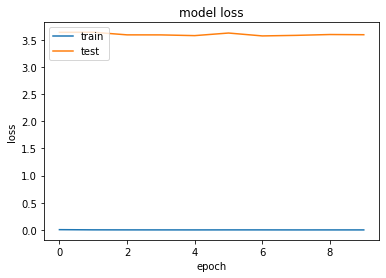

In [47]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

the validation/test loss plateued at 48th epoch hence we need to make a train limit at 48th epoch

# Model Saving and Serialization

In [46]:
# Save model and weights
model_name = 'kag45_Model2_25pcentval_adamopt.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json2.json", "w") as json_file:
    json_file.write(model_json)

# TEST DATA PROCESSING AND PREDICTING

In [25]:
#Processing and Augmenting

dffn = pd.DataFrame(columns=['feature'])
dff_noise = pd.DataFrame(columns=['feature'])
dff_speedpitch = pd.DataFrame(columns=['feature'])
cnt = 0

# loop feature extraction over the entire dataset
for file in tqdm(sample_sub['fn']):
    
    # first load the audio 
    X, sample_rate = librosa.load(file
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  
                                 )

    # take mfcc and mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=np.array(sample_rate), 
                                        n_mfcc=13),
                    axis=0)
    
    dffn.loc[cnt] = [mfccs]   

    # random shifting (omit for now)
    # Stretch
    # pitch (omit for now)
    # dyn change
    
    # noise 
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    dff_noise.loc[cnt] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    dff_speedpitch.loc[cnt] = [aug]   

    cnt += 1

dffn.head()

100%|██████████| 1017/1017 [03:46<00:00,  4.90it/s]


,feature
0,"[-9.903543, -8.758002, -10.975795, -9.476487, ..."
1,"[-42.83981, -42.876278, -42.692635, -42.772118..."
2,"[-29.247925, -29.130037, -35.96887, -41.200073..."
3,"[-44.39936, -44.13117, -44.2246, -44.39936, -4..."
4,"[-44.606525, -44.253525, -47.84052, -47.30944,..."


In [26]:
#just creating an empty dataframe to join with dffn
dffp = pd.DataFrame(columns=['feature2'])

In [27]:
# combine 
dffn = pd.concat([dffp,pd.DataFrame(dffn['feature'].values.tolist())],axis=1)
dff_noise = pd.concat([dffp,pd.DataFrame(dff_noise['feature'].values.tolist())],axis=1)
dff_speedpitch = pd.concat([dffp,pd.DataFrame(dff_speedpitch['feature'].values.tolist())],axis=1)
print(dffn.shape,dff_noise.shape,dff_speedpitch.shape)

(1017, 217) (1017, 217) (1017, 217)


In [28]:
#stacking the 3 datasets together
dffn = pd.concat([dffn,dff_noise,dff_speedpitch],axis=0,sort=False)
dffn=dffn.fillna(0)

dffn.head()

,feature2,0,1,2,3,4,5,6,7,8,...,206,207,208,209,210,211,212,213,214,215
0,0,-9.903543,-8.758002,-10.975795,-9.476487,-7.658809,-9.811097,-10.080063,-11.040907,-15.542448,...,-14.040772,-15.676284,-14.055505,-13.769380,-14.353079,-13.186202,-7.133275,2.087755,6.026888,6.36832
1,0,-42.839809,-42.876278,-42.692635,-42.772118,-42.801773,-42.707748,-42.652054,-42.677315,-42.670864,...,-42.622055,-42.624329,-42.609516,-42.603840,-42.627354,-42.627354,0.000000,0.000000,0.000000,0.00000
2,0,-29.247925,-29.130037,-35.968868,-41.200073,-42.793987,-42.996208,-42.417778,-42.881477,-43.411453,...,-46.216805,-46.011349,-45.466045,-44.844337,-44.917229,-45.225769,0.000000,0.000000,0.000000,0.00000
3,0,-44.399361,-44.131168,-44.224602,-44.399361,-44.399361,-44.399361,-44.398907,-44.375259,-44.346676,...,-44.399361,-44.399361,-44.399361,-44.399361,-44.399361,-44.399361,0.000000,0.000000,0.000000,0.00000
4,0,-44.606525,-44.253525,-47.840519,-47.309441,-47.018703,-47.141682,-48.021511,-50.285698,-52.090622,...,-43.302151,-44.225998,-39.630291,-35.808933,-34.067200,-36.698990,0.000000,0.000000,0.000000,0.00000


In [29]:
#dropping unneccessary column
dffn  = dffn.drop(['feature2',], axis=1)

In [30]:
# Lets do data normalization 
mean = np.mean(dffn, axis=0)
std = np.std(dffn, axis=0)

dffn = (dffn - mean)/std


# Check the dataset now 
dffn[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
150,-1.329662,-1.092646,-1.053723,-0.982803,-1.040168,-1.062709,-1.064472,-1.047765,-1.058646,-1.196139,...,-0.114994,-0.268537,-0.374637,-0.443276,-0.472203,-0.587959,0.212313,0.209394,0.207605,0.208767
151,-1.163932,-0.973096,-0.693813,-0.613911,-0.537052,-0.392767,-0.434851,-0.603777,-0.688199,-0.643675,...,-0.836339,-0.773722,-0.890193,-0.905542,-0.960761,-0.903439,0.212313,0.209394,0.207605,0.208767
152,-0.348530,-0.445361,-0.843832,-0.820593,-0.828448,-0.861713,-0.887159,-0.879304,-0.876957,-0.871229,...,0.442714,0.359593,0.050591,0.117365,0.196215,0.262058,0.212313,0.209394,0.207605,0.208767
153,-0.076701,-0.193994,-0.614057,-0.968103,-0.929260,-0.967307,-1.078975,-1.107982,-1.113798,-1.003780,...,0.178418,0.170219,0.145471,0.206075,0.197258,0.226128,0.212313,0.209394,0.207605,0.208767
154,1.172806,1.189761,1.171946,1.291920,1.309563,1.222332,1.160381,1.134733,1.098353,0.963503,...,0.519554,0.372698,0.053583,-0.066004,0.008962,0.783533,0.212313,0.209394,0.207605,0.208767
155,0.861995,0.741108,0.406059,0.222961,0.074008,-0.037105,0.056522,0.170377,0.180315,0.094267,...,-0.669627,-0.645363,-0.471066,-0.423780,-0.330392,-0.143541,0.212313,0.209394,0.207605,0.208767
156,1.255306,1.347571,1.586752,1.749165,1.821877,2.035830,2.068634,2.086475,2.078064,2.014876,...,1.662893,1.763845,1.710694,1.660897,1.613087,1.464232,0.339791,0.600092,0.545468,0.542547
157,0.057402,-0.007806,-0.346985,-0.424017,-0.346788,-0.301359,-0.237832,-0.205089,-0.250622,-0.177031,...,1.563722,1.556786,1.556249,1.556500,1.556461,1.514769,0.212313,0.209394,0.207605,0.208767
158,1.370733,1.383301,1.413531,1.480143,1.605764,1.603711,1.482026,1.566296,1.647924,1.601245,...,1.988575,1.951130,1.947949,2.036364,2.041089,2.026974,1.157555,0.970432,0.765714,0.714555
159,-0.203639,-0.131011,-0.043489,-0.036396,-0.259326,-0.328555,-0.304550,-0.333589,-0.314427,-0.409982,...,-0.513124,-0.532597,-0.529927,-0.568488,-0.617986,-0.442198,0.212313,0.209394,0.207605,0.208767


In [31]:
#Adding an extra dimension
dffn = np.array(dffn)
dffn = np.expand_dims(dffn, axis=2)

## LOADING MODEL, PREDICTING AND PREPARING SUBMISSION FILE

In [32]:
#loading model and predicting with  the model
model= tf.keras.models.load_model('saved_models/kag45_Model2_25pcentval_adamopt.h5')

In [48]:
# #predicting the test set proper
ssd = model.predict(dffn)

In [49]:
#copying sample_sub into a new variable
samp = sample_sub.copy()

#obtaining column list
wwe=samp.columns

#eliminating the fn column
wwe = wwe[1:]

# creating the dataframe 
df3 = pd.DataFrame(data = ssd,  
                  index = None,  
                  columns = wwe) 

#Adding back the fn column to submission file but first assigning it to a variable
tio = sample_sub['fn']

#now we combine all datasets together
cbd =pd.concat([tio,df3], axis=1)

cbd.to_csv('Sub15.csv', index=False)

### OBSERVATIONS 

1. Train loss and val loss as well as train and val accuracy didnt plateu but kept
2. best val loss after using the adam optimizer is as follows
   Epoch 48/150
   156/156 - 48s - loss: 0.1105 - accuracy: 0.9884 - val_loss: 3.1147 -        val_accuracy: 0.3209

3. ALso submitted a csv for the above 150 epochs for adam opt but got a 
   high crazy loss of 12.6

4. 

